# Sentiment Analysis

# Data : 네이버 영화 리뷰

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_data= pd.read_table('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_data= pd.read_table('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
len(train_data), len(test_data)

(150000, 50000)

# Q1. 트레이닝 데이터를 트레이닝 셋과 벨리데이션 셋으로 분할하시오.

**규칙**
1. train : valid = 8 : 2
2. label이 골고루 분할되어 들어가도록 stratify하게 분할한다.
3. random state, seed 등은 2021로 통일
4. 변수명 :
    * x_train, x_valid
    * y_train, y_valid
5. test_data도, x와 y를 분리해둔다.
    * x_test, y_test

In [6]:
####################
## Your Code here ##
####################
from sklearn.model_selection import train_test_split
x_train, y_train = train_data['document'].values, train_data['label'].values
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=2021)
x_test, y_test = test_data['document'].values, test_data['label'].values

x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape

((120000,), (30000,), (50000,), (120000,), (30000,), (50000,))

# Q2. x를 문장들이 담긴 리스트로 변환하시오.

ex> ['와 이 영화 재밌음', '크아앙 울부짖었다' ,... ]

In [7]:
####################
## Your Code here ##
####################
# 숫자만 있는 경우 tokenizer에서 에러가 나기 때문에, str 변환
x_train = list(map(str, x_train.tolist()))
x_valid = list(map(str, x_valid.tolist()))
x_test = list(map(str, x_test.tolist()))

# Q3. X를 tokenize하고, index의 sequence로 바꾸어 내시오.

**규칙**
1. 상위 40000개 단어만 사용하기로 한다.

In [8]:
####################
## Your Code here ##
####################
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 40000
tk = Tokenizer(num_words=max_words, lower=False)
tk.fit_on_texts(x_train)
x_train = tk.texts_to_sequences(x_train)
x_valid = tk.texts_to_sequences(x_valid)
x_test = tk.texts_to_sequences(x_test)

# Q4. 문장의 길이를 통일하시오.

**규칙**
1. pad는 문장의 앞에 덧댈 것.
2. 문장 최대 길이는 40


In [9]:
####################
## Your Code here ##
####################
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40
x_train = pad_sequences(x_train, maxlen=max_len)
x_valid = pad_sequences(x_valid, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# Q5. X에서, 0으로만 데이터를 제거하시오.

In [10]:
####################
## Your Code here ##
####################
not0idx = x_train.sum(1) > 0
x_train = x_train[not0idx]
y_train = y_train[not0idx]

not0idx = x_valid.sum(1) > 0
x_valid = x_valid[not0idx]
y_valid = y_valid[not0idx]

not0idx = x_test.sum(1) > 0
x_test = x_test[not0idx]
y_test = y_test[not0idx]

# Q6. 모델링 하시오.

**규칙**
* compile까지 마치시오.
* 모델 구조는 아래와 같다.
    1. Embedding layer : 임베딩 차원 192
    2. Conv1D : 필터수 128개, 윈도우 사이즈 5, swish
    3. Conv1D : 필터수 128개, 윈도우 사이즈 5, swish
    4. MaxPool1D : 필터사이즈 2
    5. Bidirectional layer :
        * 정방향 : LSTM, 48
        * 역방향 : LSTM, 48
    6. Bidirectional layer :
        * 정방향 : LSTM, 64
        * 역방향 : GRU, 64
    7. MaxPool1D : 필터사이즈 2
    7. Bidirectional layer :
        * 정방향 : GRU, 96
        * 역방향 : LSTM, 96
    8. Conv1D : 128개, 윈도우 사이즈 6, swish
    9. Flatten
    10. Fully connected, 노드 1024개, swish
    10. 적절한 아웃풋레이어.

In [11]:
####################
## Your Code here ##
####################
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D, MaxPool1D, Bidirectional, GRU, LSTM

In [12]:
####################
## Your Code here ##
####################

# 세션 클리어
K.clear_session()
# 모델 구성
# 0. input
il = Input(shape=(max_len))
# 1. Embedding layer : 임베딩 차원 192
hl = Embedding(max_words, 192, input_length=max_len)(il)
# 2. Conv1D : 필터수 128개, 윈도우 사이즈 5, swish
hl = Conv1D(128, 5, padding='same', activation='swish')(hl)
# 3. Conv1D : 필터수 128개, 윈도우 사이즈 5, swish
hl = Conv1D(128, 5, padding='same', activation='swish')(hl)
# 4. MaxPool1D : 필터사이즈 2
hl = MaxPool1D(2)(hl)
# 5. Bidirectional layer :
#     * 정방향 : LSTM, 48
#     * 역방향 : LSTM, 48
hl = Bidirectional(LSTM(48, return_sequences=True))(hl)
# 6. Bidirectional layer :
#     * 정방향 : LSTM, 64
#     * 역방향 : GRU, 64
forward_layer = LSTM(64, return_sequences=True)
backward_layer = GRU(64, return_sequences=True, go_backwards=True)
hl = Bidirectional(layer=forward_layer, backward_layer=backward_layer)(hl)
# 7. MaxPool1D : 필터사이즈 2
hl = MaxPool1D(2)(hl)
# 8. Bidirectional layer :
#     * 정방향 : GRU, 96
#     * 역방향 : LSTM, 96
forward_layer = GRU(96, return_sequences=True)
backward_layer = LSTM(96, return_sequences=True, go_backwards=True)
hl = Bidirectional(layer=forward_layer, backward_layer=backward_layer)(hl)
# 9. Conv1D : 128개, 윈도우 사이즈 6, swish
hl = Conv1D(128, 6, padding='same', activation='swish')(hl)
# 10. Flatten
hl = Flatten()(hl)
# 11. Fully connected, 노드 1024개, swish
hl = Dense(1024, activation='swish')(hl)
# 12. 적절한 아웃풋레이어.
ol = Dense(1, activation='sigmoid')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 192)           7680000   
                                                                 
 conv1d (Conv1D)             (None, 40, 128)           123008    
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 20, 96)           67968     
 l)                                                          

# Q7. Early Stopping을 이용하여 모델을 학습시키시오.

**규칙**
1. 트레이닝셋의 15%는 validation set으로 둔다.
2. batch size는 128 ~ 512 사이로 결정한다.
3. 10000 epochs
2. 10 epochs 이내에 개선이 안되면 stopping
3. 가장 성능이 좋았을 때의 가중치로 복원할 것


In [13]:
####################
## Your Code here ##
####################
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                    epochs=10000, callbacks=[es], batch_size=512)

Epoch 1/10000
221/221 [==============================] - 72s 211ms/step - loss: 0.4640 - accuracy: 0.7552 - val_loss: 0.3695 - val_accuracy: 0.8345
Epoch 2/10000
221/221 [==============================] - 23s 104ms/step - loss: 0.2812 - accuracy: 0.8814 - val_loss: 0.3702 - val_accuracy: 0.8353
Epoch 3/10000
221/221 [==============================] - 15s 70ms/step - loss: 0.1983 - accuracy: 0.9201 - val_loss: 0.4137 - val_accuracy: 0.8301
Epoch 4/10000
221/221 [==============================] - 13s 60ms/step - loss: 0.1224 - accuracy: 0.9505 - val_loss: 0.5956 - val_accuracy: 0.8249
Epoch 5/10000
221/221 [==============================] - 12s 54ms/step - loss: 0.0830 - accuracy: 0.9660 - val_loss: 0.6858 - val_accuracy: 0.8091
Epoch 6/10000
221/221 [==============================] - 12s 53ms/step - loss: 0.0652 - accuracy: 0.9727 - val_loss: 0.7825 - val_accuracy: 0.8124
Epoch 7/10000
221/221 [==============================] - 11s 50ms/step - loss: 0.0558 - accuracy: 0.9766 - val_loss:

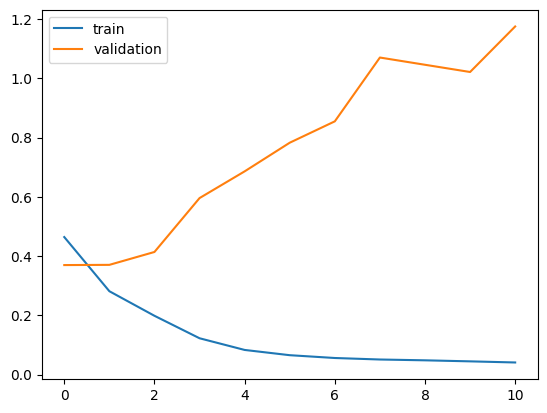

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Q8. 테스트 셋위에서 평가를 하시오.

0. positive : 1, negative : 0
1. positive로 간주하는 기준을 [ 5%, 10%, ... , 95% ] 19개로 가져간다.
    * 예시) 두번째 기준은 positive할 확률이 10%만 넘어가도 postive하다고 간주한다.
2. 각 19개 기준에 대하여, model의 sensitivity 변화를 출력한다.
    * optional) 시각화를 하여도 좋다.
3. 각 19개 기준에 대하여, model의 'positive' class의 precision 변화를 출력한다.
    * optional) 시각화를 하여도 좋다.


In [15]:
####################
## Your Code here ##
####################
model.evaluate(x_test, y_test)

1465/1465 [==============================] - 11s 8ms/step - loss: 0.3763 - accuracy: 0.8308


[0.37629443407058716, 0.8307800889015198]

In [16]:
y_pred = model.predict(x_test)

1465/1465 [==============================] - 12s 6ms/step


In [34]:
from sklearn.metrics import recall_score
rate = list(range(5, 100, 5))
recall = []
for r in rate:
    pred = np.where(y_pred * 100 > r, 1, 0)
    score = recall_score(y_test, pred)
    recall.append(score)

In [35]:
print(recall)

[0.9867800212539851, 0.9708820403825718, 0.9521785334750266, 0.93394261424017, 0.915664187035069, 0.8964505844845908, 0.8742189160467587, 0.8516896918172158, 0.8247821466524974, 0.8010626992561105, 0.7731349628055261, 0.7441870350690755, 0.712731137088204, 0.6750265674814028, 0.6340063761955367, 0.5861849096705632, 0.529691817215728, 0.44722635494155155, 0.30478214665249737]


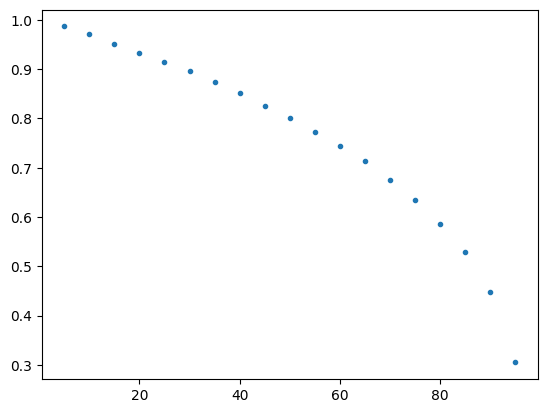

In [37]:
plt.plot(rate, recall, '.')
plt.show()

# Q9. 다음 텍스트가 positive할 확률을 출력하시오.

"이 영화는 명작인지, 망작인지 너무나 혼란스럽고 즐겁다."




In [38]:
####################
## Your Code here ##
####################
text = "이 영화는 명작인지, 망작인지 너무나 혼란스럽고 즐겁다."
texts = [text]
texts = tk.texts_to_sequences(texts)
texts = pad_sequences(texts, maxlen=max_len)
pred = model.predict(texts)
print(pred)

1/1 [==============================] - 0s 136ms/step
[[0.8761479]]


# Q10. 아래 주어진 문장을, 주어진 조건에 따라 분석하시오.

review = '명작이지ㅋ 특히 명절때만 되면 티비에서 참 많이 해줬었는데, 웃기기도하고, 액션도 가미되었고...특히 가족같은 형제라는 주제가 안방에 잘 먹혔던거 같다.'

* 루프문과 print를 이용하여 아래와 같은 방식으로 출력하시오.
    1. positive확률 :  50%,  인풋 : '명작이지ㅋ'
    2. positive확률 :  55%, 인풋 : '명작이지ㅋ 특히'
    3. positive확률 : 56%, 인풋 : '명작이지ㅋ 특히 명절때만'
    4. .....(계속 한 단어씩 증가 시키기)
    5. positive확률 : 98%, 인풋 : '명작이지~ 같다.'
* 인풋으로 사용한 문장과 확률은 명확히 출력되어야 한다.
    * 나머지는 출력되지 않아도 좋다.

In [43]:
####################
## Your code here ##
####################

text = "명작이지ㅋ 특히 명절때만 되면 티비에서 참 많이 해줬었는데, 웃기기도하고, 액션도 가미되었고...특히 가족같은 형제라는 주제가 안방에 잘 먹혔던거 같다."
text = text.split(' ')
for i in range(len(text)):
    word = ' '.join(text[:i + 1])
    texts = [word]
    texts = tk.texts_to_sequences(texts)
    texts = pad_sequences(texts, maxlen=max_len)
    pred = model.predict(texts)
    print(f"positive 확률 : {pred[0][0] * 100 :.2f}, 인풋 : {word}")

1/1 [==============================] - 0s 26ms/step
positive 확률 : 36.72, 인풋 : 명작이지ㅋ
1/1 [==============================] - 0s 26ms/step
positive 확률 : 69.24, 인풋 : 명작이지ㅋ 특히
1/1 [==============================] - 0s 27ms/step
positive 확률 : 69.24, 인풋 : 명작이지ㅋ 특히 명절때만
1/1 [==============================] - 0s 29ms/step
positive 확률 : 67.92, 인풋 : 명작이지ㅋ 특히 명절때만 되면
1/1 [==============================] - 0s 30ms/step
positive 확률 : 73.68, 인풋 : 명작이지ㅋ 특히 명절때만 되면 티비에서
1/1 [==============================] - 0s 29ms/step
positive 확률 : 57.03, 인풋 : 명작이지ㅋ 특히 명절때만 되면 티비에서 참
1/1 [==============================] - 0s 27ms/step
positive 확률 : 61.24, 인풋 : 명작이지ㅋ 특히 명절때만 되면 티비에서 참 많이
1/1 [==============================] - 0s 43ms/step
positive 확률 : 61.24, 인풋 : 명작이지ㅋ 특히 명절때만 되면 티비에서 참 많이 해줬었는데,
1/1 [==============================] - 0s 39ms/step
positive 확률 : 82.97, 인풋 : 명작이지ㅋ 특히 명절때만 되면 티비에서 참 많이 해줬었는데, 웃기기도하고,
1/1 [==============================] - 0s 50ms/step
positive 확률 : 58.63, 인풋 : 명작이지ㅋ 특히 명절때만 되면 티비에서 참 많